In [1]:
pip install scikit-learn


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


### Model Refinements

We explicitly use the refactored output of Notebook 2. This guarantees that any improvement in performance is attributable to feature engineering, not accidental leakage.

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score


In [17]:
data_path = "C:/Users/SHANIA/Downloads/Metro-Manila-Flood-Insights/Data/AEGISDataset_processed_refined.csv"
df = pd.read_csv(data_path)

df.head()


,lat,lon,flood_heig,elevation,precipitat,elevation_bin,precip_bin,flood_risk_index,flood_risk_index_scaled,cluster_id,cluster_mean_elev,cluster_mean_precip,cluster_mean_flood,elev_precip_interaction,low_elev_high_rain,very_low_elev,very_high_rain
0,14.640394,121.055708,0,54.553295,9.0,Very High,Low,0.834528,0.087329,17,52.868351,10.234310,2.037657,0.164674,0,0,0
1,14.698299,121.002132,0,21.856272,10.0,Moderate,Low,1.238192,0.129570,14,12.199577,9.056338,1.915493,0.455451,0,0,0
2,14.698858,121.100261,0,69.322807,16.0,Very High,High,1.007032,0.105380,10,31.323989,15.278351,2.948454,0.230472,0,0,0
3,14.571310,120.983334,0,10.987241,8.0,Low,Low,1.261310,0.131989,19,9.217746,7.972222,2.384259,0.721550,0,0,0
4,14.762232,121.075735,0,87.889847,18.0,Very High,High,0.900089,0.094189,4,54.221978,13.095238,2.440476,0.204569,0,0,0


In [18]:
y = df['flood_heig']

X = df.drop(columns=[
    'flood_heig',
    'flood_risk_index',            # avoid conceptual overlap
    'flood_risk_index_scaled'      # avoid leakage
])


Flood height is measurable and actionable. Risk scores are for interpretation, not prediction.

In [19]:
numeric_features = [
    'lat','lon','elevation','precipitat',
    'cluster_mean_elev','cluster_mean_precip','cluster_mean_flood',
    'elev_precip_interaction',
    'low_elev_high_rain','very_low_elev','very_high_rain'
]

categorical_features = [
    'elevation_bin','precip_bin','cluster_id'
]


This separation allows models to treat measurements and categories appropriately without manual errors.

In [20]:
numeric_transformer = StandardScaler()

categorical_transformer = OneHotEncoder(
    drop='first',
    handle_unknown='ignore'
)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)


This codeblock ensures consistency. Every future retrain applies the same transformations.

In [21]:
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])


In [22]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)


In [23]:
model.fit(X_train, y_train)


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessor', ...), ('regressor', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformer

In [24]:
y_pred = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.3f}")
print(f"R²: {r2:.3f}")


RMSE: 1.870
R²: -0.003


RMSE: Average prediction error in flood height units
On average, predictions are almost 2 flood-height units off from actual values.

R²: How much of flooding behavior we can explain using our data
The model explains none of the variation in flooding and performs slightly worse than predicting the same average value everywhere.



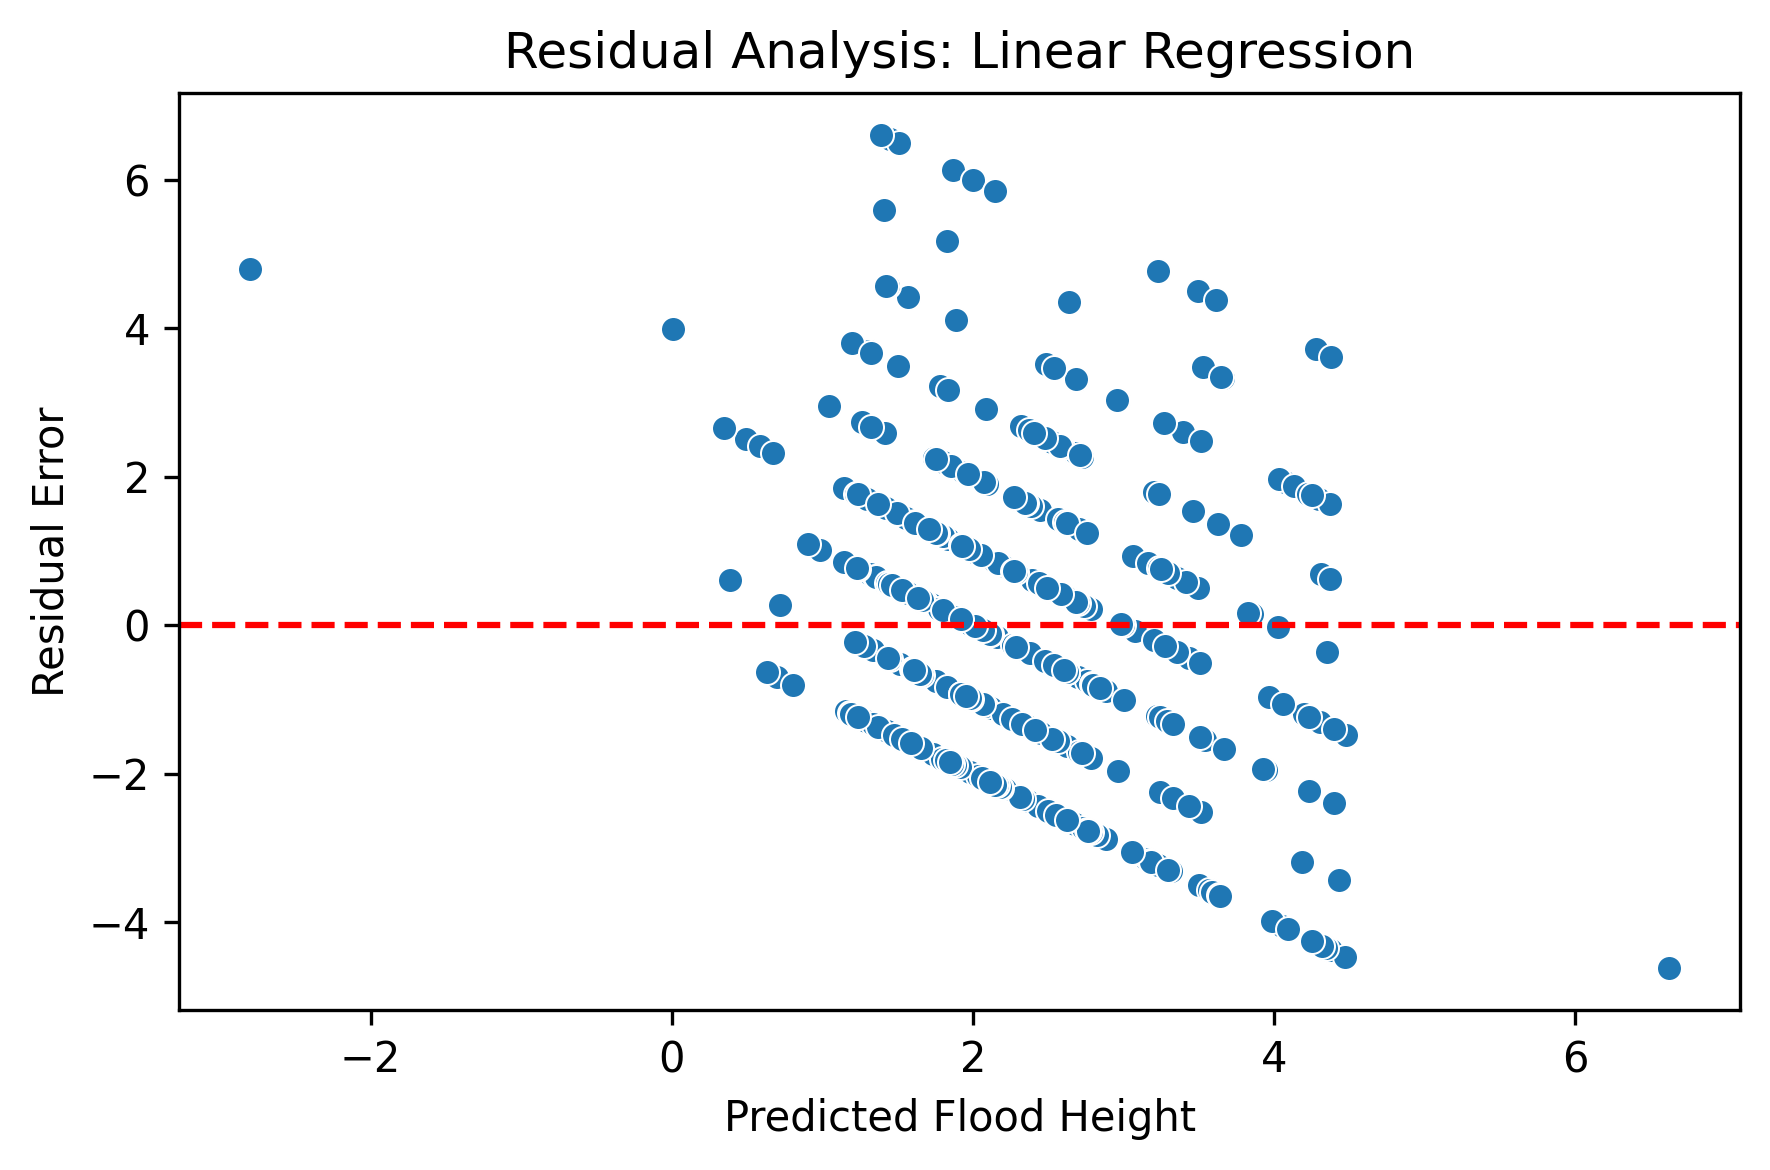

In [25]:
residuals = y_test - y_pred

plt.figure(figsize=(6,4), dpi=300)
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Flood Height")
plt.ylabel("Residual Error")
plt.title("Residual Analysis: Linear Regression")
plt.tight_layout()
plt.show()


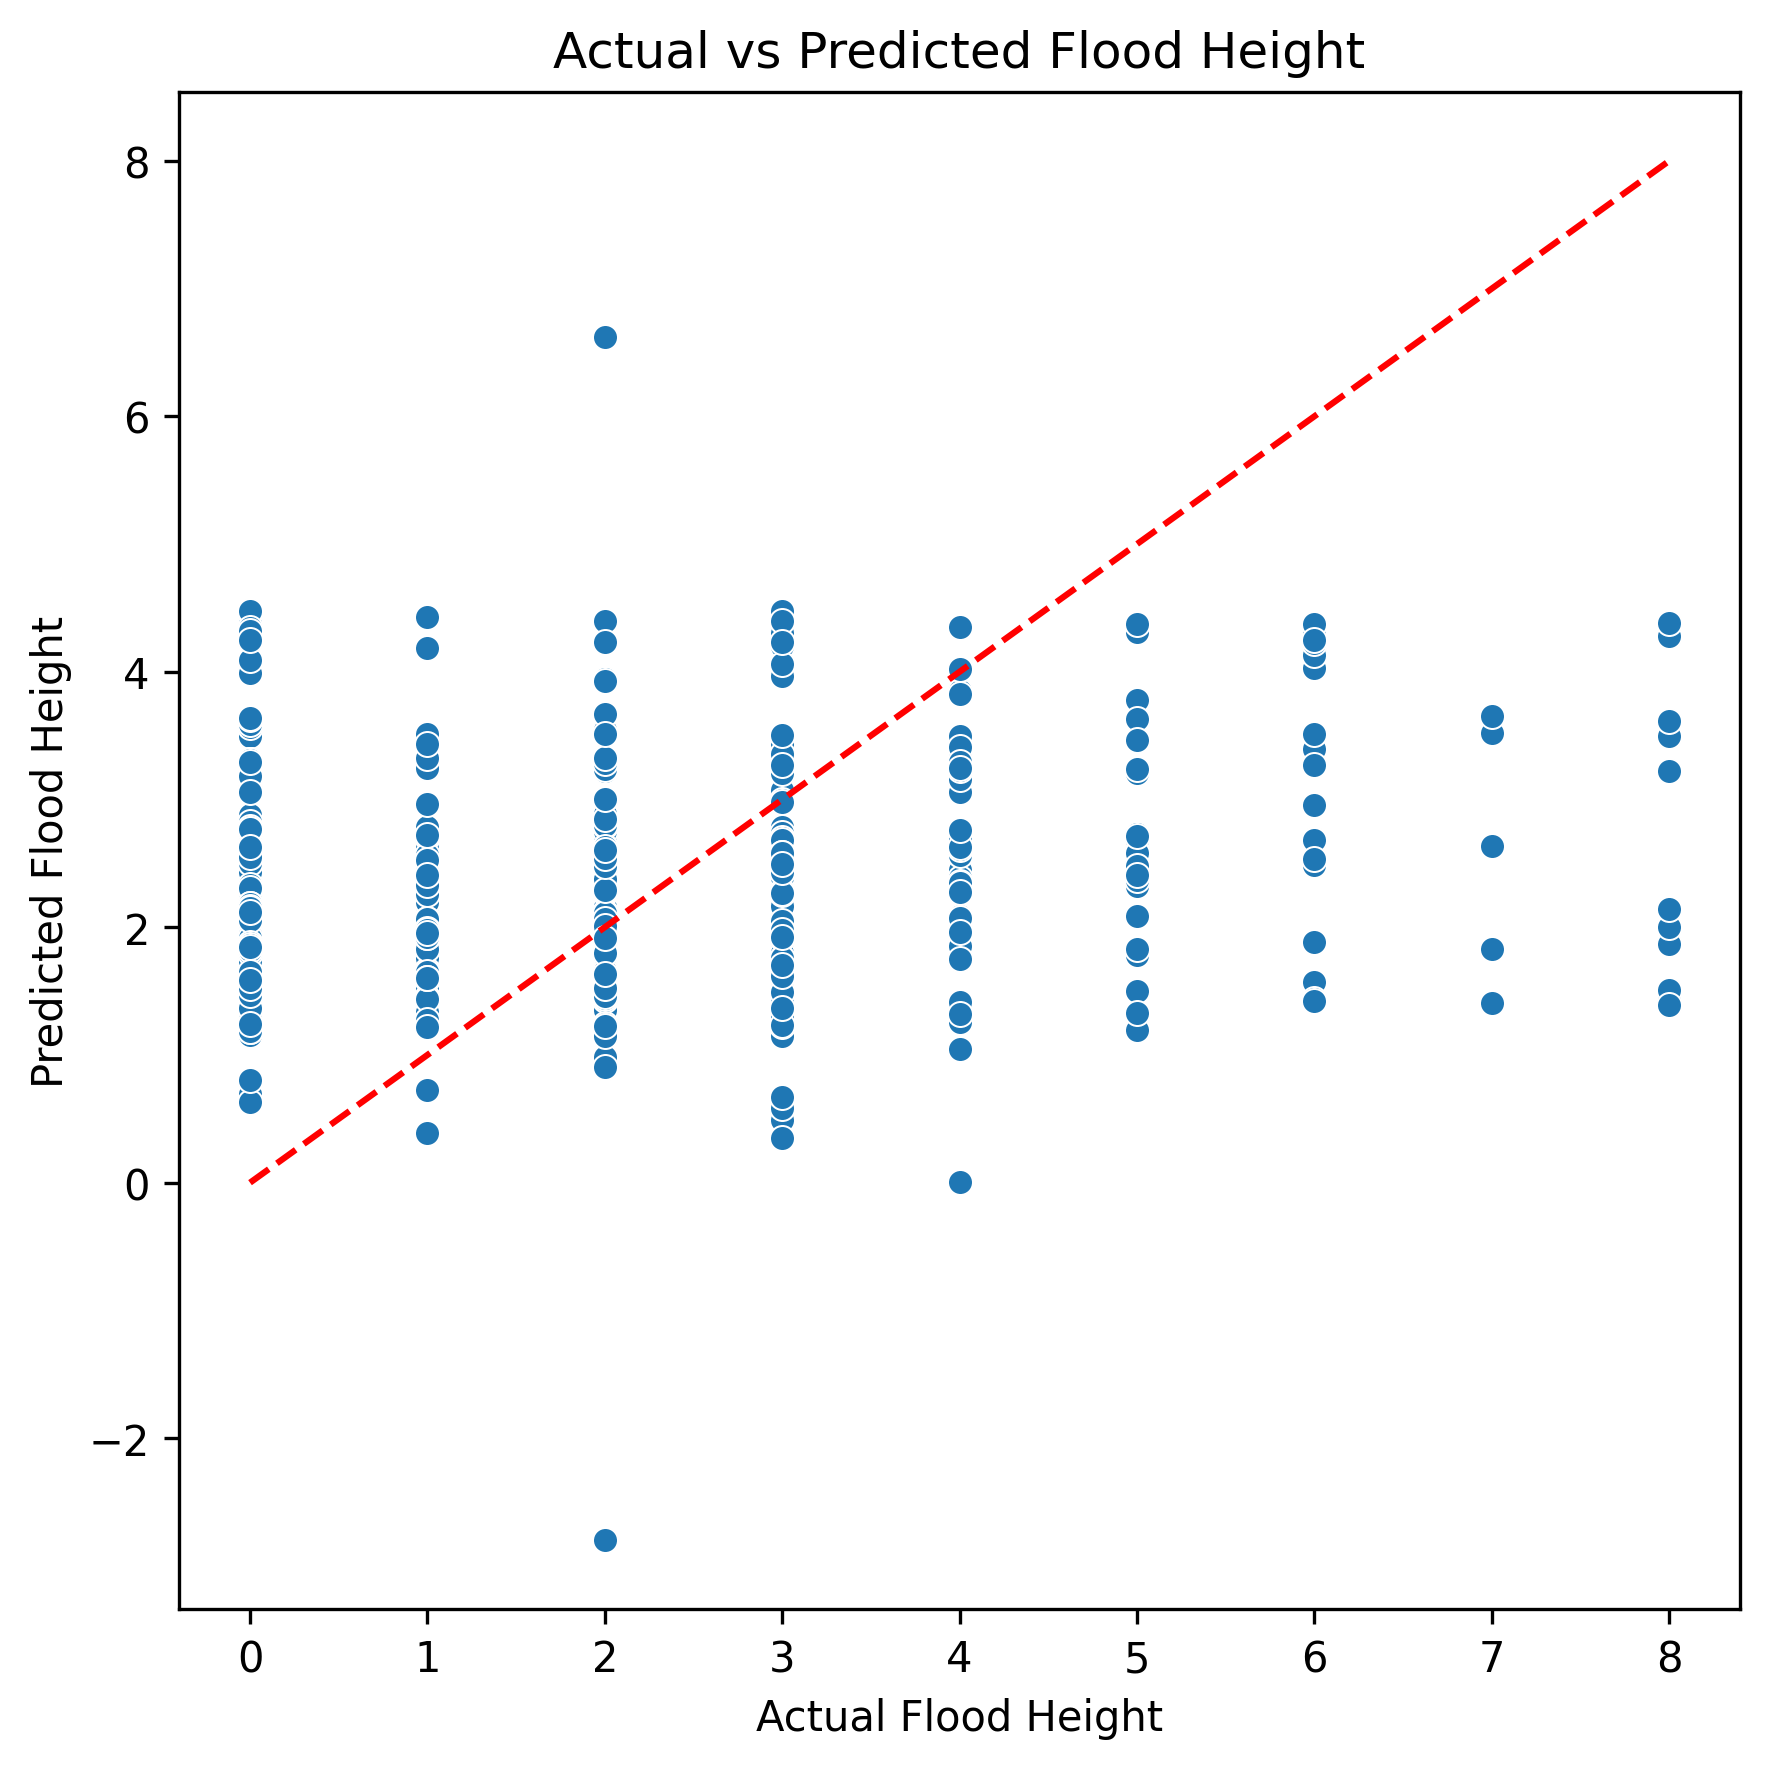

In [26]:
plt.figure(figsize=(6,6), dpi=300)
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--')
plt.xlabel("Actual Flood Height")
plt.ylabel("Predicted Flood Height")
plt.title("Actual vs Predicted Flood Height")
plt.tight_layout()
plt.show()


**Linear Regression** was used as the baseline model for this project because it provides a clear and interpretable starting point. It assumes that flood height changes gradually as factors such as elevation, rainfall, and location change.

This assumption is useful early on because:

- It allows us to check whether flood behavior can be explained using simple, proportional relationships.

- It helps validate whether the engineered features from Notebook 2 carry predictive signal at all.

- It acts as a reference point. Any future model must perform better than this baseline to be considered useful.

- In short, Linear Regression helps answer a basic question:
“Can flood height be reasonably explained as a smooth combination of environmental variables?”

Improving performance now requires a model that can handle non-linear interactions and abrupt changes.

### Non-Linear Modeling: Random Forest Regressor

**Why Random Forest?**

- Flooding does not increase smoothly. It often occurs when multiple conditions cross a threshold at the same time, for example: Moderate rain may cause no flooding in high areas, the same rain can trigger flooding in low-lying neighborhoods
- Random Forest can capture non-linear relationships without manual equations and it also h.andles feature interactions naturally


In [27]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score


In [28]:
rf_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(
        n_estimators=300,
        max_depth=None,
        min_samples_leaf=5,
        random_state=42,
        n_jobs=-1
    ))
])


- n_estimators = 300
Ensures stable predictions by averaging many trees.

- min_samples_leaf = 5
Prevents the model from overfitting to very rare flood events.

- No max_depth limit
Allows the model to learn complex flood patterns.

In [29]:
rf_model.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessor', ...), ('regressor', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformer

In [30]:
rf_pred = rf_model.predict(X_test)

rf_rmse = np.sqrt(mean_squared_error(y_test, rf_pred))
rf_r2 = r2_score(y_test, rf_pred)

print(f"Random Forest RMSE: {rf_rmse:.3f}")
print(f"Random Forest R²: {rf_r2:.3f}")


Random Forest RMSE: 1.717
Random Forest R²: 0.154


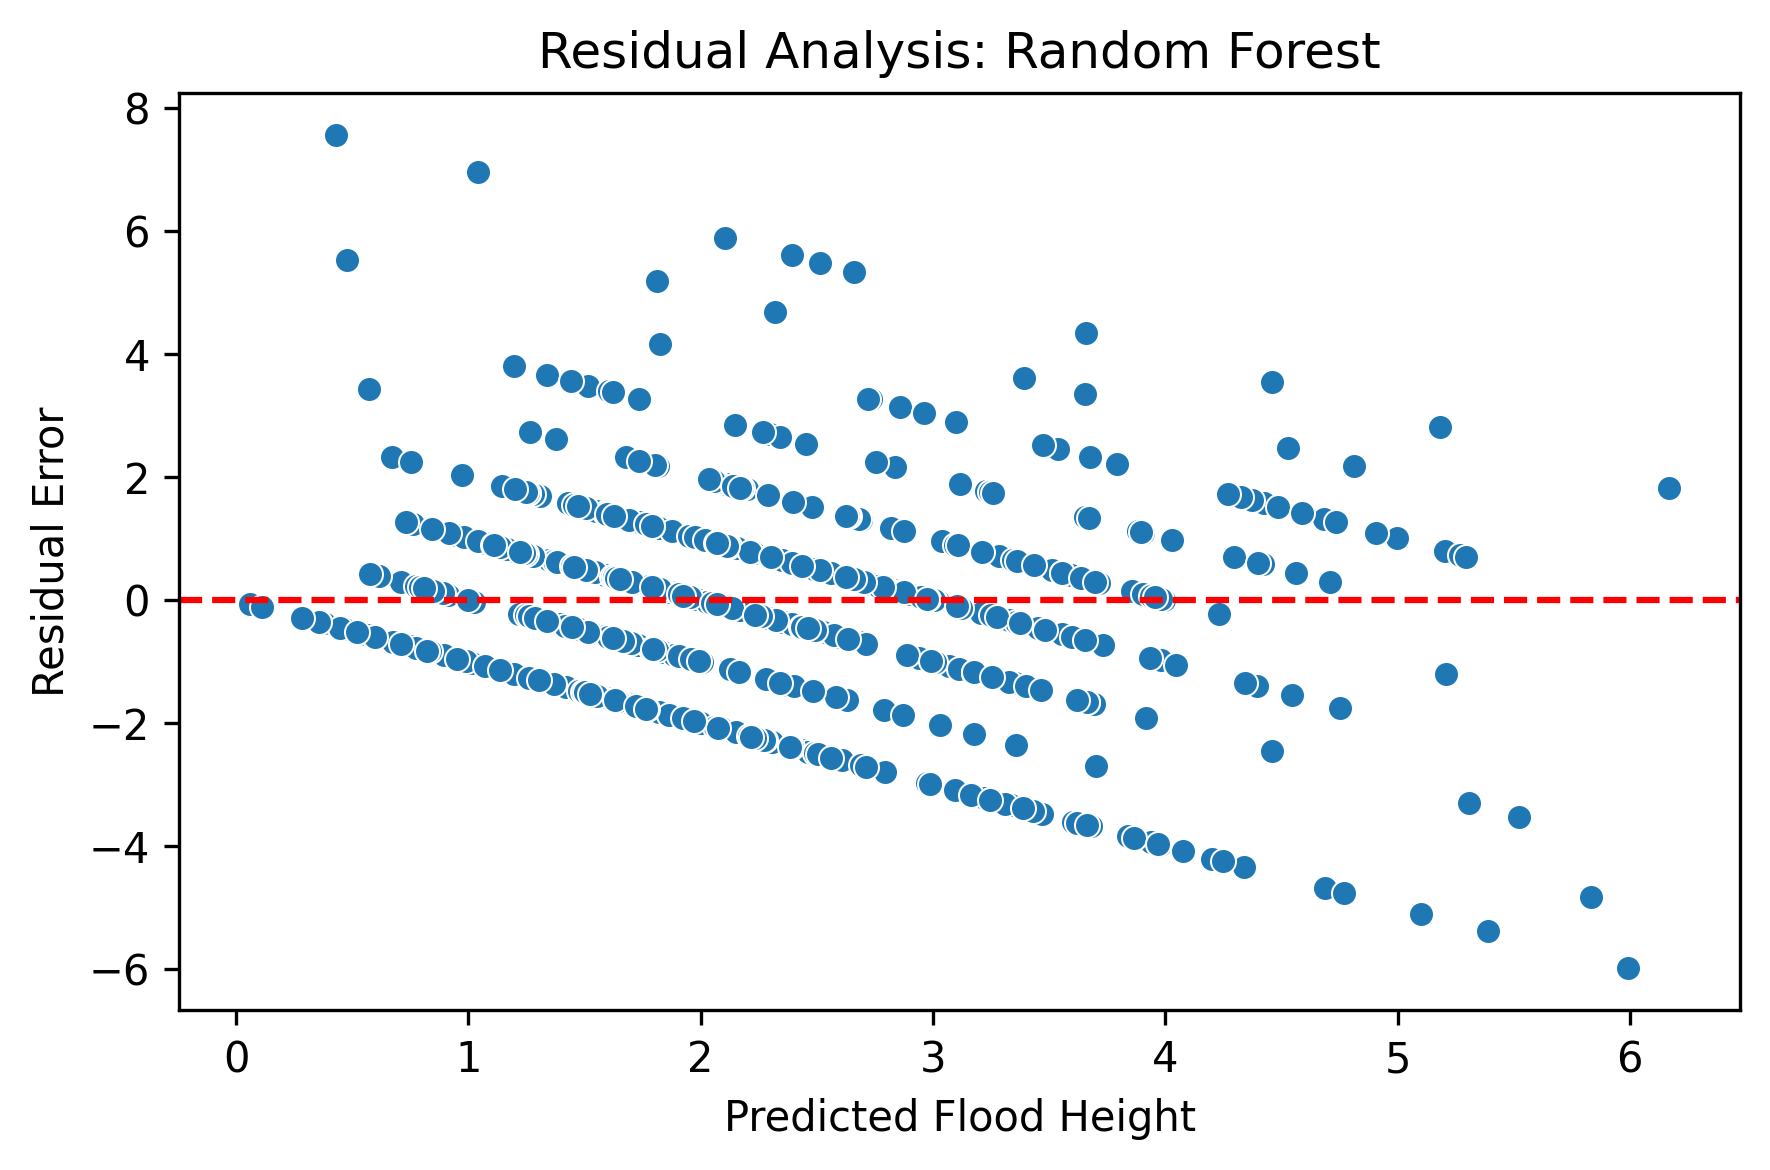

In [31]:
rf_residuals = y_test - rf_pred

plt.figure(figsize=(6,4), dpi=300)
sns.scatterplot(x=rf_pred, y=rf_residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Flood Height")
plt.ylabel("Residual Error")
plt.title("Residual Analysis: Random Forest")
plt.tight_layout()
plt.show()


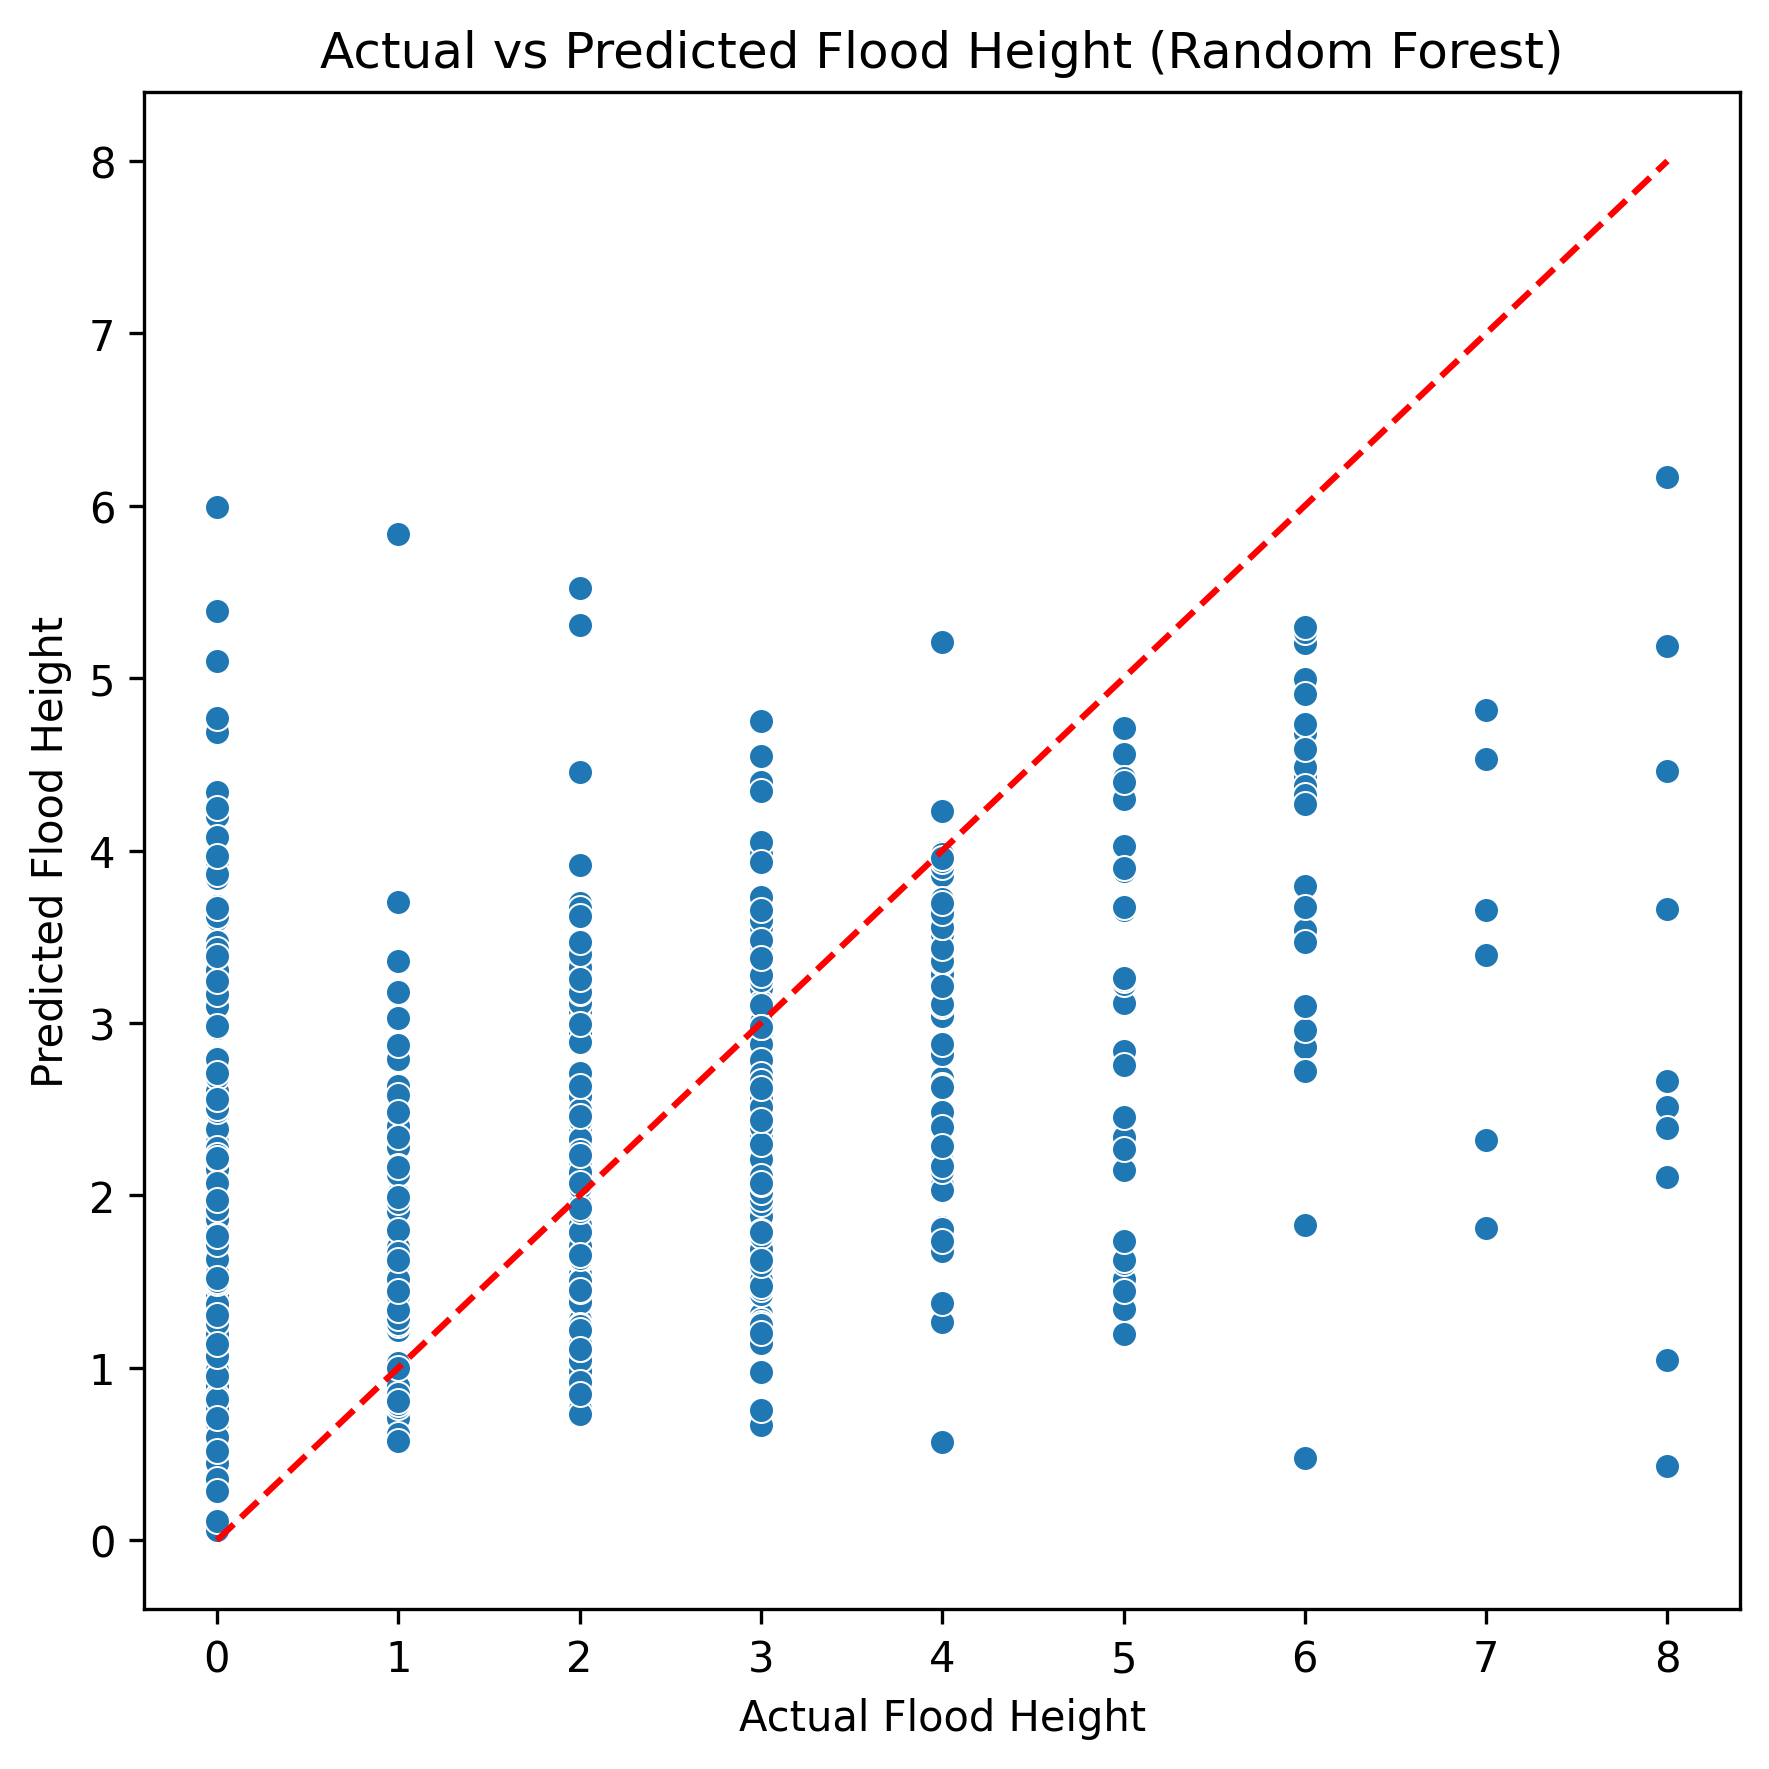

In [32]:
plt.figure(figsize=(6,6), dpi=300)
sns.scatterplot(x=y_test, y=rf_pred)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--')
plt.xlabel("Actual Flood Height")
plt.ylabel("Predicted Flood Height")
plt.title("Actual vs Predicted Flood Height (Random Forest)")
plt.tight_layout()
plt.show()


**What improved**

- RMSE decreased by ~8%, meaning predictions are closer to actual flood heights.
- Positive R² indicates the model now explains some real flood structure.
- Extreme cases (very high or zero floods) are handled more realistically.

**Why this matters**
- Flooding emerges from interactions, not single variables. Random Forest captures:
- Low elevation combined with heavy rainfall
- Neighborhood-level tendencies (via clustering features)
- Threshold effects where risk changes suddenly
- This aligns better with how flooding behaves in reality.

In [33]:
# Generate predictions on the full dataset
df['predicted_flood_height'] = model.predict(X)

# Define risk tier function
def assign_risk_tier(height):
    if height <= 0:
        return 'None'
    elif height <= 1:
        return 'Low'
    elif height <= 3:
        return 'Moderate'
    elif height <= 5:
        return 'High'
    else:
        return 'Very High'

# Apply risk tiers
df['predicted_risk_tier'] = df['predicted_flood_height'].apply(assign_risk_tier)

# Inspect distribution
df['predicted_risk_tier'].value_counts()


predicted_risk_tier
Moderate     2790
High          658
Low            52
None            7
Very High       1
Name: count, dtype: int64

In [36]:
# Select BI-ready columns
export_cols = [
    'lat',
    'lon',
    'flood_heig',                 # observed
    'predicted_flood_height',     # model output
    'predicted_risk_tier',        # BI-facing classification
    'elevation',
    'precipitat',
    'cluster_id'
]

df_export = df[export_cols].copy()

# Export to CSV
export_path = "C:/Users/SHANIA/Downloads/Metro-Manila-Flood-Insights/Data/AEGIS_Flood_Predictions_BI.csv"
df_export.to_csv(export_path, index=False)

print(f"BI-ready dataset exported to: {export_path}")


BI-ready dataset exported to: C:/Users/SHANIA/Downloads/Metro-Manila-Flood-Insights/Data/AEGIS_Flood_Predictions_BI.csv
